### This notebook tests different normalization schemes for binning tracer transports in salinity coordinates.

In [2]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms

from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from glob import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams.update({'font.size': 18})

### Open the normalized exchange flow profiles. Display the dataset because I'll probably forget what tracers I decided to test. But generally will be volume and salinity variance TEF.

In [3]:
path = '../analysis/normalized/tef_nested_10min_xi_50_250_eta_150_350_znormalized.nc'

ds = xr.open_dataset(path)

ds

<xarray.Dataset>
Dimensions:     (depth_bin: 50, ocean_time: 720, salt_bin: 200)
Coordinates:
  * depth_bin   (depth_bin) float64 -64.35 -63.05 -61.75 ... -3.25 -1.95 -0.65
  * ocean_time  (ocean_time) datetime64[ns] 2010-06-15T00:10:00 ... 2010-06-20
  * salt_bin    (salt_bin) float64 0.1 0.3 0.5 0.7 0.9 ... 39.3 39.5 39.7 39.9
Data variables:
    Qnet        (ocean_time, salt_bin, depth_bin) float64 ...
    Qin         (ocean_time, depth_bin) float64 ...
    Qout        (ocean_time, depth_bin) float64 ...
    Qsvarnet    (ocean_time, salt_bin, depth_bin) float64 ...
    Qsvarin     (ocean_time, depth_bin) float64 ...
    Qsvarout    (ocean_time, depth_bin) float64 ...
    svarin      (ocean_time, depth_bin) float64 ...
    svarout     (ocean_time, depth_bin) float64 ...
    voladv      (ocean_time, depth_bin) float64 ...
    svaradv     (ocean_time, depth_bin) float64 ...
Attributes:
    Description:  Exchange flow Dataset
    Author:       Dylan Schlichting
    Created:      2021-02-12T09:21:29.099705

In [8]:
ds.Qnet

<xarray.DataArray 'Qnet' (ocean_time: 720, salt_bin: 200, depth_bin: 50)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
  * depth_bin   (depth_bin) float64 -64.35 -63.05 -61.75 ... -3.25 -1.95 -0.65
  * ocean_time  (ocean_time) datetime64[ns] 2010-06-15T00:10:00 ... 2010-06-20
  * salt_bin    (salt_bin) float64 0.1 0.3 0.5 0.7 0.9 ... 39.3 39.5 39.7 39.9

Text(0.5, 1.0, '$Q_{vol}/dV$ [s$^{-1}$]')

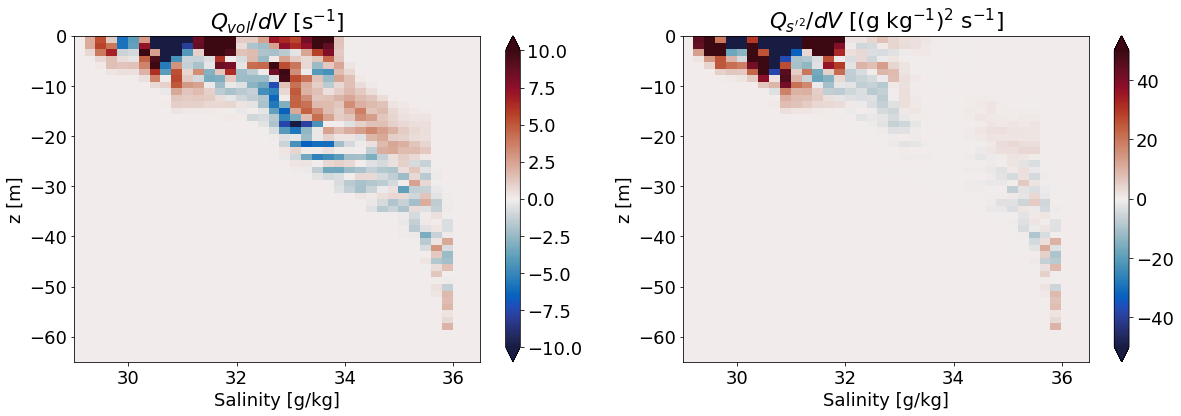

In [104]:
fig, axs = plt.subplots(1,2, figsize = (20,6), )

ds.Qnet.sum('ocean_time').plot(y = 'depth_bin',
                                cmap = cmo.balance,
                                ax = axs[0],
                                vmax = 10,
                                cbar_kwargs = {'label': ''}
                                 )

ds.Qsvarnet.sum('ocean_time').plot(y = 'depth_bin', 
                                    cmap = cmo.balance,
                                    ax = axs[1],
                                    vmax = 50,
                                    cbar_kwargs = {'label': ''}
                                   )

axs[1].set_yticks(np.arange(-60, 6, 10))

for ax in axs.flat:
    ax.set(ylabel = 'z [m]', 
           xlabel = 'Salinity [g/kg]',
           xlim = (29,36.5),
           ylim = (-0, -65)
           )
    ax.invert_yaxis()

axs[1].set_title(r'$Q_{s^\prime{^2}}/dV$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axs[0].set_title(r'$Q_{vol}/dV$ [s$^{-1}$]')


Text(0.5, 1.0, '$Q_{vol}/dV$ [s$^{-1}$]')

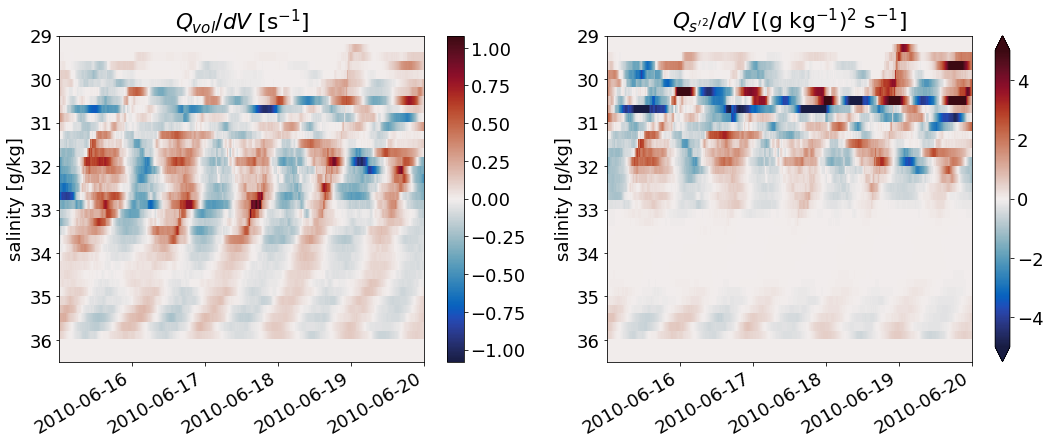

In [105]:
fig, axs = plt.subplots(1,2, figsize = (18,6), )

ds.Qnet.sum('depth_bin').plot(y = 'salt_bin',
                                cmap = cmo.balance,
                                ax = axs[0],
                            
                                cbar_kwargs = {'label': ''}
                                 )

ds.Qsvarnet.sum('depth_bin').plot(y = 'salt_bin', 
                                    cmap = cmo.balance,
                                    ax = axs[1],
                                    vmax = 5,
                                    cbar_kwargs = {'label': ''}
                                   )

# axs[1].set_yticks(np.arange(-60, 6, 10))

for ax in axs.flat:
    ax.set(ylabel = 'salinity [g/kg]', 
           xlabel = '',
           ylim = (29,36.5),
           )
    ax.invert_yaxis()

axs[1].set_title(r'$Q_{s^\prime{^2}}/dV$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axs[0].set_title(r'$Q_{vol}/dV$ [s$^{-1}$]')



In [70]:
path = '../analysis/normalized/chi/dissipation_histogram_10min_xi50250_eta150350_notintegrated.nc'
chi = xr.open_dataset(path).chi

/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


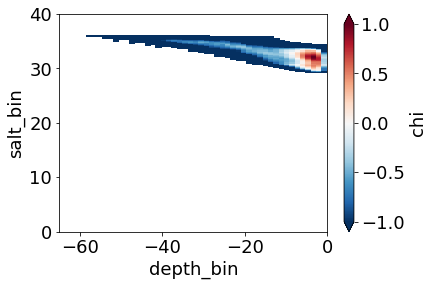

In [74]:
chi.sum('ocean_time')).plot(vmax = 1)

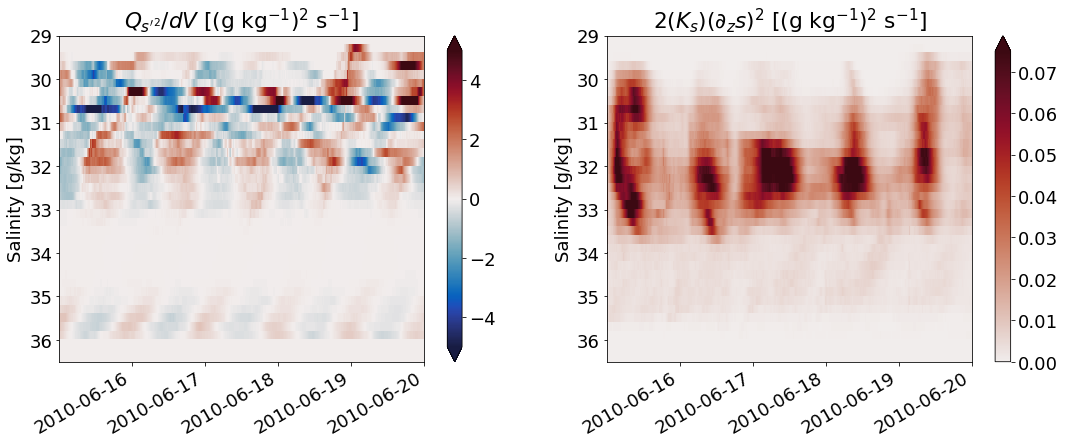

In [92]:
fig, axs = plt.subplots(1,2, figsize = (18,6), )


ds.Qsvarnet.sum('depth_bin').plot(y = 'salt_bin', 
                                    cmap = cmo.balance,
                                    ax = axs[0],
                                    vmax = 5,
                                    cbar_kwargs = {'label': ''}
                                   )

chi.sum('depth_bin').plot(y = 'salt_bin',
                          cmap = cmo.amp,
                          cbar_kwargs = {'label': ''},
                          vmax = 0.075
                                   )

axs[1].set_yticks(np.arange(-60, 6, 10))

for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (29,36.5),
           )
    ax.invert_yaxis()

axs[0].set_title(r'$Q_{s^\prime{^2}}/dV$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axs[1].set_title('$2(K_s)(\partial_z s)^2$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axs[1].set_yticks(range(29,37))

Text(0.5, 1.0, '$2(K_s)(\\partial_z s)^2$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')

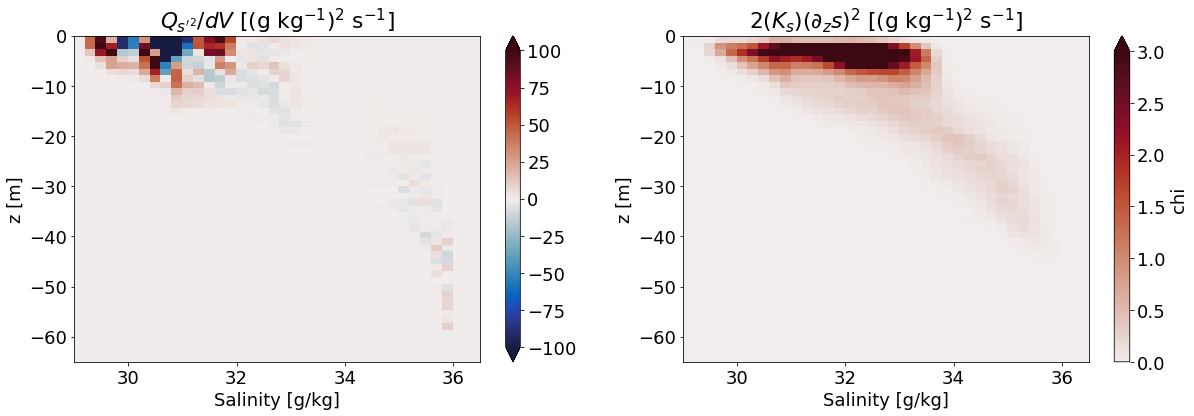

In [103]:
fig, axs = plt.subplots(1,2, figsize = (20,6), )


ds.Qsvarnet.sum('ocean_time').plot(y = 'depth_bin', 
                                    cmap = cmo.balance,
                                    ax = axs[0],
                                    vmax = 100,
                                    cbar_kwargs = {'label': ''}
                                   )

chi.sum('ocean_time').plot(y = 'depth_bin',
                                     cmap = cmo.amp,
                                     vmax = 3,
                                     vmin = 0
                                     )

axs[1].set_yticks(np.arange(-60, 6, 10))

for ax in axs.flat:
    ax.set(ylabel = 'z [m]', 
           xlabel = 'Salinity [g/kg]',
           xlim = (29,36.5),
           ylim = (-0, -65)
           )
    ax.invert_yaxis()

axs[0].set_title(r'$Q_{s^\prime{^2}}/dV$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axs[1].set_title('$2(K_s)(\partial_z s)^2$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
